In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from datetime import timezone
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# function to get stonk data
def get_stonk(stonk_code,hist_date='01-01-2010'):
    today = dt.today()
    
    # converting dates to Unix timestamps
    unix_hist = dt.strptime(hist_date,'%m-%d-%Y').replace(tzinfo=timezone.utc).timestamp()
    unix_today = today.replace(tzinfo=timezone.utc).timestamp()
    
    # getting stonk history from Yahoo! Finance
    link = (f'https://query1.finance.yahoo.com/v7/finance/download/'
            f'{stonk_code}?period1={int(unix_hist)}&period2={int(unix_today)}&interval=1d&events=history')
    b = requests.get(link)
    s = str(b.content,'utf-8')
    s_io = StringIO(s)
    stonks = pd.read_csv(s_io,encoding='utf-8',parse_dates=['Date'])
    
    # converting Date column to numeric data
    try:
        stonks['Date'] = stonks['Date'].map(dt.toordinal)
    except:
        pass
    return stonks

In [3]:
# function for train/test splitting, scaling, and smoothing
def split_scale(stonk_df,smooth_window,EMA_interval=21):
    # splitting data
    train, test = train_test_split(stonk_df.dropna(),test_size=0.2,shuffle=False)
    
    # scaling data
    scaler=MinMaxScaler()
    train_scaled = pd.DataFrame()
    test_scaled = pd.DataFrame()
    for feat in stonk_df.columns:
        train_feat = []
        for di in range(0,len(train)-1,smooth_window):
            scaler.fit(train.loc[di:di+smooth_window-1,feat].values.reshape(-1,1))
            scaled_feat_train = scaler.transform(train.loc[di:di+smooth_window-1,feat].values.reshape(-1,1))
            train_feat = np.concatenate((train_feat,scaled_feat_train.reshape(-1)))
        train_scaled[feat] = train_feat
        scaled_feat_test = scaler.transform(test.loc[:,feat].values.reshape(-1,1))
        test_scaled[feat] = scaled_feat_test.reshape(-1)
    
    # smoothing training data using exponential moving average (EMA)
    mult = 2/(EMA_interval+1)
    EMA = 0.0
    for ind in range(len(train_scaled)):
        EMA = train_scaled.iloc[ind]*mult + EMA*(1-mult)
        train_scaled.iloc[ind] = EMA
    return train_scaled, test_scaled

In [4]:
stonks = get_stonk('AMC')
# stonks

In [5]:
try:
    date = stonks.pop('Date')
except:
    pass
train_scaled, test_scaled = split_scale(stonks,smooth_window=500)

In [6]:
# train_scaled

In [7]:
# test_scaled

In [8]:
# defining how far ahead user wants to predict
days_ahead = 30 # change to user input
for df in [train_scaled,test_scaled]:
    for ind in df.index:
        try:
            df.loc[ind,f'{days_ahead}_days'] = df.loc[ind+days_ahead,'Open']
        except:
            pass
    df.dropna(inplace=True)

In [9]:
# defining inputs & outputs
x_train = train_scaled.drop(f'{days_ahead}_days',axis=1)
y_train = train_scaled.loc[:,f'{days_ahead}_days']
x_test = test_scaled.drop(f'{days_ahead}_days',axis=1)
y_test = test_scaled.loc[:,f'{days_ahead}_days']

# reshaping inputs & outputs for LSTM model
x_train = np.reshape(x_train.values,(x_train.values.shape[0],x_train.values.shape[1],1))
x_test = np.reshape(x_test.values,(x_test.values.shape[0],x_test.values.shape[1],1))
y_train, y_test = y_train.values, y_test.values

In [71]:
# defining and building TensorFlow LSTM model
model_lstm = tf.keras.Sequential()
# model_lstm.add(tf.keras.layers.LSTM(units=64,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=64,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=64))
model_lstm.add(tf.keras.layers.Dense(units=1))
model_lstm.compile(loss='mse',optimizer='adam')

In [72]:
# training model
model_lstm.fit(x_train,y_train,epochs=5,batch_size=512,verbose=1)

Epoch 1/5
3/3 [==============================] - 0s 19ms/step - loss: 0.2733
Epoch 2/5
3/3 [==============================] - 0s 20ms/step - loss: 0.1797
Epoch 3/5
3/3 [==============================] - 0s 20ms/step - loss: 0.0986
Epoch 4/5
3/3 [==============================] - 0s 18ms/step - loss: 0.0391
Epoch 5/5
3/3 [==============================] - 0s 16ms/step - loss: 0.0279


In [73]:
# evaluating model
model_lstm.evaluate(x_test,y_test,verbose=1)

10/10 [==============================] - 0s 3ms/step - loss: 0.3114


0.3113584816455841

In [74]:
# predicting stock price a user-inputted number of days into the future
to_predict = test_scaled.iloc[-2*days_ahead:-days_ahead]
to_predict.drop(f'{days_ahead}_days',axis=1,inplace=True)
x_predict = np.reshape(to_predict.values,(to_predict.values.shape[0],to_predict.values.shape[1],1))
predictions = model_lstm.predict(x_predict)

c:\users\nolan\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


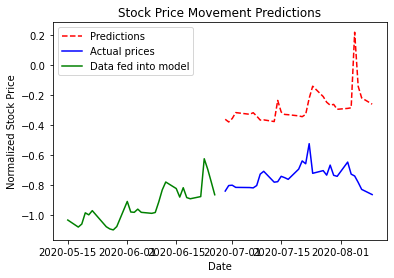

In [76]:
plt.plot(date.iloc[-days_ahead:].map(dt.fromordinal),
         predictions.reshape(predictions.shape[0],predictions.shape[1]).T[0],'r--',label='Predictions')
plt.plot(date.iloc[-days_ahead:].map(dt.fromordinal),test_scaled.iloc[-days_ahead:].Open,'b-',label='Actual prices')
plt.plot(date.iloc[-2*days_ahead:-days_ahead],to_predict.Open,'g-',label='Data fed into model')
# plt.plot(date.iloc[test_scaled.iloc[-days_ahead:].index].map(dt.fromordinal),
#          test_scaled.iloc[-days_ahead:].Open,'b-',label='Open')
# plt.plot(date.iloc[to_predict.index+30].map(dt.fromordinal),to_predict.Open,'g-',label=f'Open {days_ahead} days prior')
plt.legend(loc=0,frameon=True)
plt.xlabel('Date')
plt.ylabel('Normalized Stock Price')
plt.title('Stock Price Movement Predictions')
plt.show()

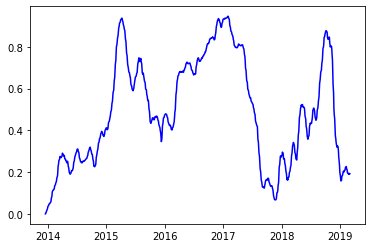

In [52]:
plt.plot(date.iloc[train_scaled.index].map(dt.fromordinal),train_scaled.Open,'b-')
plt.show()

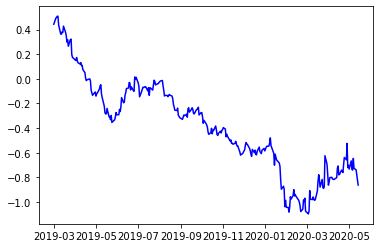

In [53]:
plt.plot(date.iloc[len(train_scaled)+test_scaled.index].map(dt.fromordinal),test_scaled.Open,'b-')
plt.show()